<a href="https://colab.research.google.com/github/ArthurFDLR/pose-classification-kit/blob/master/BodyModel_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤙 Pose Classification kit body model design

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os

%tensorflow_version 2.x
import tensorflow
from tensorflow import keras

print('Available GPU:')
!nvidia-smi -L
print('\nTensorFlow use GPU at: {}'.format(tensorflow.test.gpu_device_name()))

!pip install pose-classification-kit
from pose_classification_kit.datasets import BODY25, bodyDataset, dataAugmentation

## Import dataset

In [6]:
dataset = bodyDataset(testSplit=.2, shuffle=True, bodyModel=BODY25)
x_train = dataset['x_train']
y_train = dataset['y_train_onehot']

x_train.shape, y_train.shape

Dataset loaded from https://raw.githubusercontent.com/ArthurFDLR/pose-classification-kit/master/pose_classification_kit/datasets/BodyPose_Dataset.csv


((8040, 25, 2), (8040, 20))

## Data augmentation

In [7]:
x_scale, y_scale = dataAugmentation(x_train, y_train, augmentation_ratio=.25, scaling_factor_standard_deviation=.08, random_noise_standard_deviation=.03)
x_rotate, y_rotate = dataAugmentation(x_train, y_train, augmentation_ratio=.25, rotation_angle_standard_deviation=10, random_noise_standard_deviation=.03)
lowerBody_keypoints = [10, 11, 13, 14, 19, 20, 21, 22, 23, 24]
x_noLegs, y_noLegs = dataAugmentation(x_train, y_train, augmentation_ratio=.25, remove_specific_keypoints=lowerBody_keypoints, random_noise_standard_deviation=.03)
x_partial, y_partial = dataAugmentation(x_train, y_train, augmentation_ratio=.25, remove_rand_keypoints_nbr=4, random_noise_standard_deviation=.03)

x_train_augmented = np.concatenate((x_train, x_scale, x_rotate, x_noLegs, x_partial), axis=0)
y_train_augmented = np.concatenate((y_train, y_scale, y_rotate, y_noLegs, y_partial), axis=0)

x_train_augmented.shape, y_train_augmented.shape

((16080, 25, 2), (16080, 20))

## Dataset creation

In [10]:
model_train_history = {}
input_dim = x_train.shape[1:]
validation_split = 0.20
epochs = 15

In [13]:
model = keras.models.Sequential(name = 'CNN-2Conv1D-64x3filter-2dense-2x128',
                                   layers =
    [
        keras.layers.InputLayer(input_shape=input_dim),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=3),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(), 
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(len(dataset['labels']), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train_augmented,
    y=y_train_augmented,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=1,
)

Model: "CNN-2Conv1D-64x3filter-2dense-2x128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 23, 64)            448       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               57472     
_________________________________________________________________
dense_6 (Dense)              (N

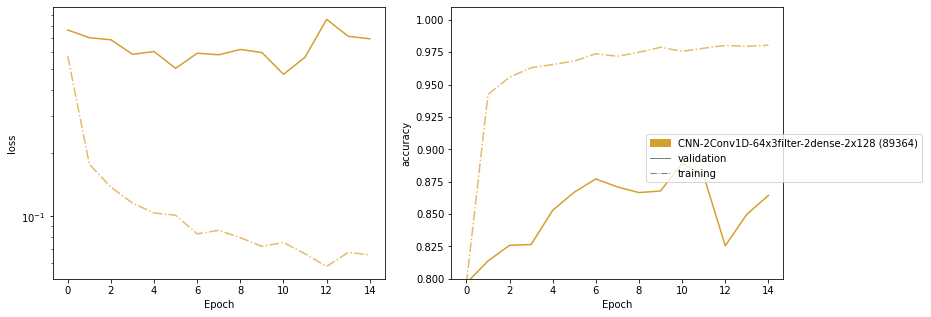

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
colors_graph = ["#d69e2d",
                "#927ced",
                "#73bd4d",
                "#e462c0",
                "#eb5e52"]
handles = []

for (model, history), color in zip(model_train_history.items(), colors_graph):
    label = '{} ({})'.format(model.name, model.count_params())
    axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color)
    axs[1].plot(history.history['val_accuracy'], c=color)
    handles.append(mpatches.Patch(color=color, label=label))

for ax in axs:
    ax.set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.8,1.01)

handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))

fig.subplots_adjust(right=0.85)
fig.legend(handles=handles,
           loc="center right",
           borderaxespad=1)

## Model testing

In [22]:
model.evaluate(x=dataset['x_test'], y=dataset['y_test_onehot'])

63/63 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 0.9920


[0.02946239523589611, 0.9919999837875366]